To-do List:
- Try MCMC sampling
- simulate noisy circuits
- custom priors
- custom guide

In [28]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pickle
%matplotlib inline

import torch
from torch.distributions import constraints
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam, SGD

In [3]:
assert pyro.__version__.startswith('1.8.6')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = True

In [4]:
name = "GHZ_2"
filename = name+"_statistics"
path = "data/"+filename

probabilities = []
with open(path, "r") as f:
    lines = f.read().splitlines()
for line in lines:
    outcome, freq = line.split(" ")
    number = int(outcome)
    probabilities.append(float(freq))
options = range(len(probabilities))
print(probabilities)
n_samples = 10000
data = np.random.choice(options, n_samples, p=probabilities)

[0.014998596803814605, 0.15511065626598572, 0.12525881227615243, 0.005689757606629152, 0.14083295265364282, 0.013379998151701574, 0.2299266067388926, 0.008542609533421808, 0.16565172112297352, 0.14060828884678478]


In [5]:
class QuantumStateTomography(nn.Module):
    def __init__(self, n=3, alpha = 0.1, K=1, POVM=None, sigma =1):
        super().__init__()
        #define hyperparameters
        self.N = 2**n        # size of system (2^num qubits)
        self.alpha = alpha   # sparsity of the density matrix
        self.K = K           # rank of the density matrix
        if POVM is not None:
            self.POVM = torch.from_numpy(POVM).type(torch.complex64) # measurement set used
        else:
            self.POVM = None
        self.sigma = sigma   # variance of the complex vectors

    def model(self, data):
        #draw a probability distribution over K pure states
        theta = pyro.sample("theta", dist.Dirichlet(torch.ones(self.K)*self.alpha))
        
        #generate K pure states
        with pyro.plate("pure states", self.K):
            real_part = pyro.sample("real_part", dist.MultivariateNormal(torch.zeros(self.N),self.sigma*torch.eye(self.N)))
            imag_part = pyro.sample("imag_part", dist.MultivariateNormal(torch.zeros(self.N),self.sigma*torch.eye(self.N)))
            complex_vector = torch.complex(real_part, imag_part)
            norm_vector = complex_vector / torch.norm(complex_vector, dim=-1, keepdim=True)
        norm_vector = torch.transpose(norm_vector,0,1)
        #compute the density matrix (rho)
        # theta_diag = torch.diag(theta).type(torch.complex64)
        # norm_vector_hat = torch.conj(torch.transpose(norm_vector, 0,1))
        # rho = pyro.deterministic("density matrix", torch.matmul(torch.matmul(norm_vector_hat, theta_diag), norm_vector))
        
        if self.POVM == None:
            #standard basis measurements
            squared = torch.conj(norm_vector) * norm_vector
            probabilities = (squared @ theta.type(torch.complex64))
            with pyro.plate("data", len(data)):
                return pyro.sample("obs", dist.Categorical(probabilities.real), obs=data)
        else:
            inner_prods = torch.matmul(torch.conj(self.POVM), norm_vector)
            squared = torch.conj(inner_prods) * inner_prods
            probabilities = (squared @ theta.type(torch.complex64))
            with pyro.plate("data", len(data)):
                return pyro.sample("obs", dist.Categorical(probabilities.real), obs=data)


    def guide(self, data):
        #draw a probability distribution over K pure states
        alpha = pyro.param("alpha", torch.ones(self.K)*self.alpha)
        theta = pyro.sample("theta", dist.Dirichlet(alpha))
        
        #generate K pure states
        with pyro.plate("pure states", self.K):
            real_part = pyro.sample("real_part", dist.MultivariateNormal(torch.zeros(self.N),self.sigma*torch.eye(self.N)))
            imag_part = pyro.sample("imag_part", dist.MultivariateNormal(torch.zeros(self.N),self.sigma*torch.eye(self.N)))
            complex_vector = torch.complex(real_part, imag_part)
            norm_vector = complex_vector / torch.norm(complex_vector, dim=-1, keepdim=True)
        norm_vector = torch.transpose(norm_vector,0,1)
    

In [6]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test
def setup_data_loaders(data, batch_size=128, use_cuda=False):
    root = './data'
    download = True
    random.shuffle(data)
    n = len(data)
    cutoff = int(0.9*n)
    train_set = torch.Tensor(data[:cutoff])
    test_set = torch.Tensor(data[cutoff:])

    kwargs = {'num_workers': 4, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [7]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False
smoke_test = False

# Run only for a single iteration for testing
NUM_EPOCHS = 2 if smoke_test else 100
TEST_FREQUENCY = 5

In [8]:
with open("data/GHZ_2_POVM", "rb") as f:
    POVM = pickle.load(f)

print(torch.from_numpy(POVM).type(torch.complex64))

tensor([[ 0.1193-0.3438j,  0.0476+0.1573j,  0.2642+0.1442j, -0.2018+0.1916j],
        [ 0.0102+0.1514j, -0.3274-0.1686j, -0.1533+0.2744j, -0.0175+0.4055j],
        [ 0.1132+0.2787j, -0.0140+0.3277j,  0.1858-0.3101j, -0.0431+0.2169j],
        [-0.0528-0.3258j,  0.0727-0.3010j,  0.0789-0.1981j, -0.0331+0.3890j],
        [ 0.1119+0.3272j,  0.3239+0.0615j,  0.1770+0.0124j,  0.0562+0.1762j],
        [ 0.3098+0.0853j, -0.1559+0.1882j, -0.0502-0.4656j, -0.3953+0.0542j],
        [-0.3295-0.0540j,  0.3019-0.1538j,  0.3275+0.1736j, -0.3458-0.0075j],
        [ 0.3423+0.1358j, -0.1893-0.2297j, -0.1521+0.2799j, -0.2982-0.0127j],
        [-0.2214-0.2086j, -0.2069+0.3518j, -0.0951-0.2924j, -0.1566-0.2255j],
        [-0.2759+0.0807j, -0.2520+0.1792j, -0.2045+0.0915j, -0.1463+0.2402j]])


In [41]:
train_loader, test_loader = setup_data_loaders(data,batch_size=128, use_cuda=USE_CUDA)
n_qubits = 2
n_states = 1

# clear param store
pyro.clear_param_store()

qst = QuantumStateTomography(n=n_qubits, K=n_states, POVM=POVM)
optimizer = Adam({"lr": LEARNING_RATE})
autoguide = pyro.infer.autoguide.AutoNormal(qst.model)
svi = SVI(qst.model, autoguide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
pbar = tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    pbar.set_description("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        pbar.set_description("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 099]  average training loss: 2.0883: 100%|█| 100/100 [02:36<00:00,  1.57s


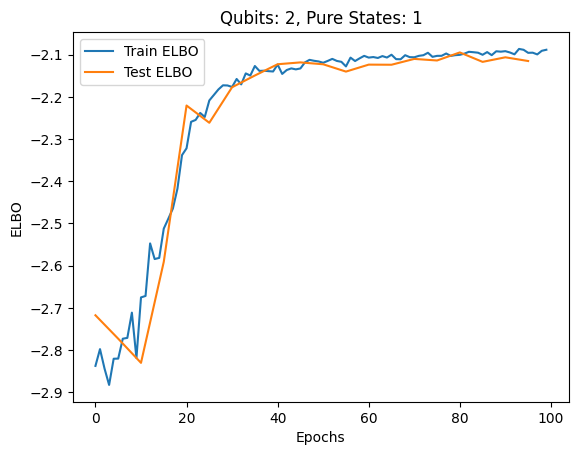

In [42]:
epochs = np.arange(len(train_elbo))
plt.plot(epochs, train_elbo, label='Train ELBO')
epochs = np.arange(len(test_elbo))
plt.plot(epochs*TEST_FREQUENCY, test_elbo, label='Test ELBO')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.legend()
plt.title(f"Qubits: {n_qubits}, Pure States: {n_states}")
plt.show()

In [43]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())
# data_ = torch.tensor(data)
# predictive_svi = Predictive(qst.model, guide=guide, num_samples=500)(data_)
# for k, v in predictive_svi.items():
#     print(f"{k}: {tuple(v.shape)}")

AutoNormal.locs.theta []
AutoNormal.scales.theta []
AutoNormal.locs.real_part [[0.04135072 0.00021552 0.06482105 0.07221879]]
AutoNormal.scales.real_part [[0.0921265  0.06898424 0.10125126 0.09203129]]
AutoNormal.locs.imag_part [[ 0.7429989  -0.00080875  0.01097346  0.75467473]]
AutoNormal.scales.imag_part [[0.10707575 0.07037342 0.06164349 0.10054676]]


In [48]:
from scipy.linalg import sqrtm
def trace_dist(a, b):
    k = a-b
    M = np.matmul(k.conj().T,k)
    B = sqrtm(M)
    return np.trace(B).real/2

def fidelity(a,b):
    k = sqrtm(a)
    M = k @ b @ k
    return (np.trace(sqrtm(M)).real)**2

In [49]:
real_part = pyro.param('AutoNormal.locs.real_part').data
imag_part = pyro.param('AutoNormal.locs.imag_part').data
theta = pyro.param('AutoNormal.locs.theta').data
vec = F.normalize(torch.complex(real_part, imag_part), p=2, dim=1).numpy()
print('vec2', vec)
print(vec.shape)


approx_DM = np.outer(vec, np.conj(vec))


with open("data/GHZ_2_density", "rb") as file:
    rho = pickle.load(file)
true_DM = rho

print(true_DM)
print(approx_DM)

print('Trace Distance:',trace_dist(approx_DM, true_DM))
print('Fidelity:', fidelity(approx_DM, true_DM))

approx_prob = np.round(np.real(np.diag(approx_DM)),3)
real_prob = np.round(np.real(np.diag(true_DM)),3)

print('approximate probabilities:',approx_prob)
print('real probabilities:', real_prob)

#print(np.round(approx_prob - real_prob,3))

vec2 [[0.03885087+0.698081j   0.00020249-0.00075986j 0.0609023 +0.01031007j
  0.06785282+0.709051j  ]]
(1, 4)
[[0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]]
[[ 4.8882651e-01+0.0000000e+00j -5.2257429e-04+1.7087742e-04j
   9.5633687e-03+4.2114187e-02j  4.9761119e-01+1.9819513e-02j]
 [-5.2257429e-04-1.7087742e-04j  6.1838500e-07+0.0000000e+00j
   4.4981070e-06-4.8364716e-05j -5.2503723e-04-1.9513609e-04j]
 [ 9.5633687e-03-4.2114187e-02j  4.4981070e-06+4.8364716e-05j
   3.8153881e-03+0.0000000e+00j  1.1442754e-02-4.2483274e-02j]
 [ 4.9761119e-01-1.9819513e-02j -5.2503723e-04+1.9513609e-04j
   1.1442754e-02+4.2483274e-02j  5.0735730e-01+0.0000000e+00j]]
Trace Distance: 0.06554947469958937
Fidelity: 0.9957035424189221
approximate probabilities: [0.489 0.    0.004 0.507]
real probabilities: [0.5 0.  0.  0.5]
